In [1]:
# Load in relevant modules
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import tree

In [56]:
# Load in the data
df = pd.read_csv('data/creditcard.csv')

In [57]:
# Basic descriptive statistics
print(f'number of rows: {len(df)}')
print(f'number of feature columns: {len(df.columns)-1}')
print(f"number of instances of fraud: {sum(df['Class'])}")

# Check for any missingness; if nothing is output, then there
# is no missingness
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(col)

number of rows: 284807
number of feature columns: 30
number of instances of fraud: 492


In [58]:
# Standard scale all the columns generated by PCA
for col in df[df.columns[1:-2]]:
    mean = np.mean(df[col])
    std = np.std(df[col])
    df[col] = df[col].apply(lambda val: (val-mean) / std)

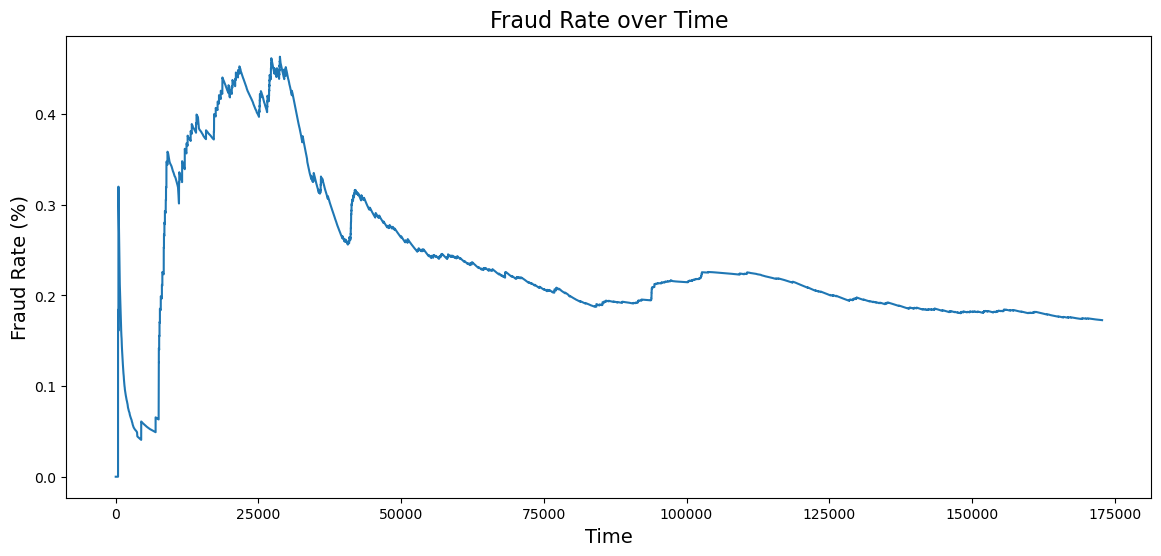

In [4]:
# Analyze the relationship between time and fraud by seeing how the fraud 
# rate changes over time. The fraud rate at time t is defined as the number 
# of instances of fraud from time 0 to time t-1 divided by the number of 
# observations from time 0 to time t-1.
observations_at_each_time_dict = dict(df.groupby('Time').agg('count')['Class'])
frauds_at_each_time_dict = dict(df.groupby('Time').agg('sum')['Class'])
observations_by_each_time_dict = {0: 0}
frauds_by_each_time_dict = {0: 0}
fraud_rate_dict = {0: 0}

prev_time = 0

for time in sorted(df['Time'].unique())[1:]:
    
    # The number of observations seen by time t is equal to the number of observations
    # seen by time t-1 plus the number of observations seen at time t-1; the same logic
    # underlies the fraud by each time calculations
    observations_by_each_time_dict[time] = observations_by_each_time_dict[prev_time] + \
    observations_at_each_time_dict[prev_time]
    
    frauds_by_each_time_dict[time] = frauds_by_each_time_dict[prev_time] + \
    frauds_at_each_time_dict[prev_time]
    
    # Calculate fraud rate by each time by dividing the number of frauds seen by time
    # t by the number of observations seen by time t
    fraud_rate_dict[time] = frauds_by_each_time_dict[time]/observations_by_each_time_dict[time]
    
    prev_time = time
    

plt.figure(figsize=(14,6))
plt.title('Fraud Rate over Time', fontsize=16)
plt.plot(fraud_rate_dict.keys(), 100*np.array(list(fraud_rate_dict.values())))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Fraud Rate (%)', fontsize=14)
plt.show()

**How to interpret chart**: "At time 25,000, approximately .4% of observations seen to that point were fraudulent."

**Takeaway**: Fraud rate has slowly decreased over time. However, after ~time=75,000 it is unclear if fraud rate is still decreasing.

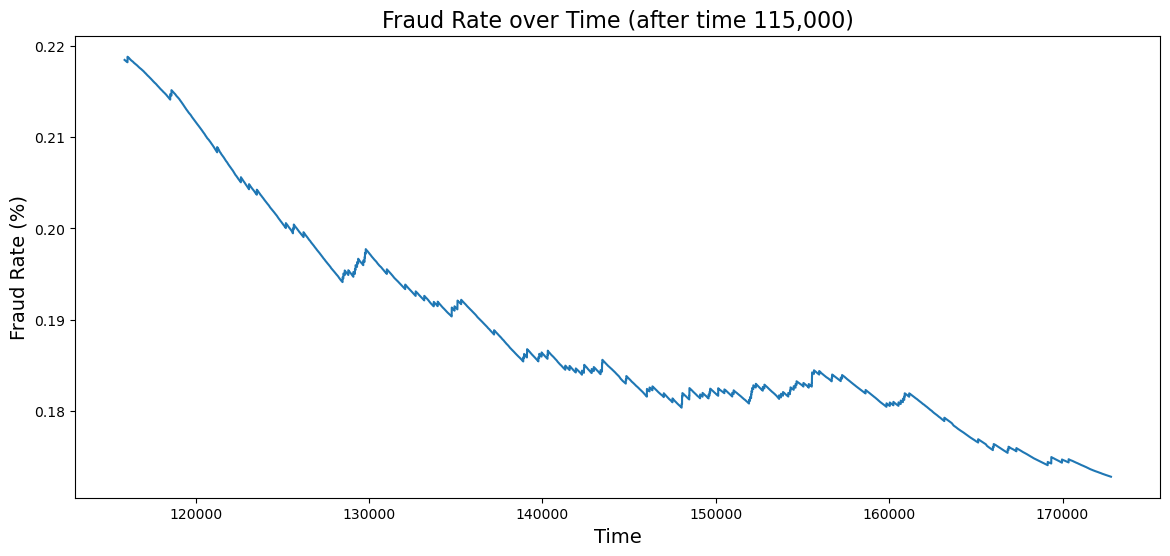

In [82]:
# Q: What is the relationship between time and fraud rate in the last third of our window?
# (i.e., after time 115,000)
plt.figure(figsize=(14,6))
plt.title('Fraud Rate over Time (after time 115,000)', fontsize=16)
plt.plot(list(fraud_rate_dict.keys())[75000:],
         100*np.array(list(fraud_rate_dict.values()))[75000:])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Fraud Rate (%)', fontsize=14)
plt.show()

**Takeaway**: Fraud rate continues to decrease at a regular rate. Because there is a clear relationship between fraud rate and time, time should play some part in our model.

KS statistic: 0.27
p value of KS statistic: 2.1703053464297685e-32
value at which two distributions are most different: $1.18


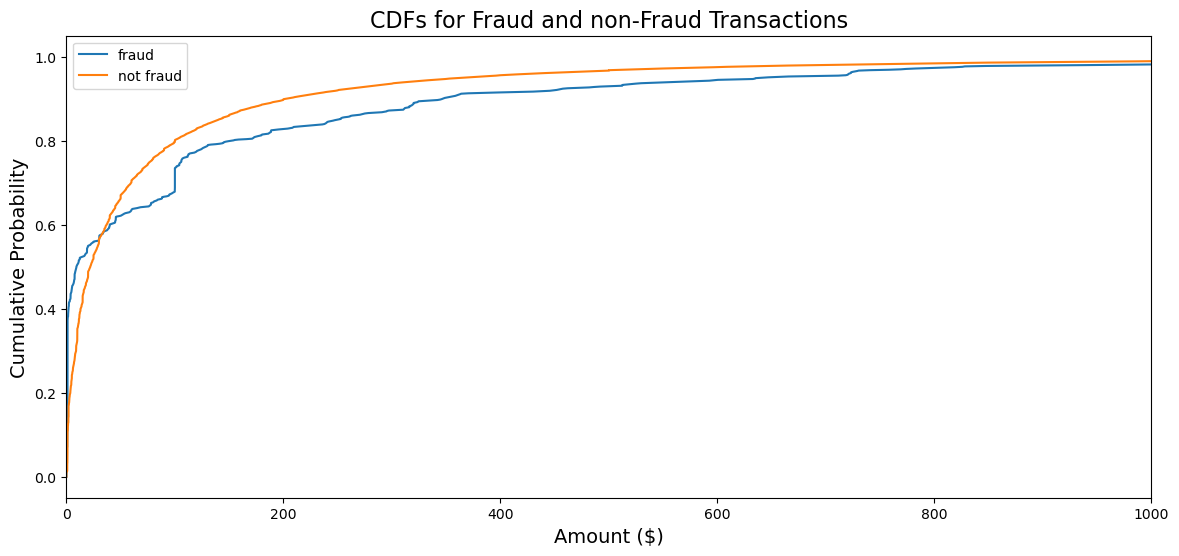

In [5]:
# Analyze the relationship between fraud and transaction amount by looking at
# the cumulative distribution functions for amounts for fraud and non-fraud
# transactions
non_fraud_cdf = {}
fraud_cdf = {}

df_fraud = df[df['Class'] == 1]
df_no_fraud = df[df['Class'] == 0]

for x in np.linspace(0, 1, 1000):
    non_fraud_cdf[x] = np.quantile(df_no_fraud['Amount'], x)
    fraud_cdf[x] = np.quantile(df_fraud['Amount'], x)
    
# Run KS analysis to compare the two distributions
ks = stats.ks_2samp(df_fraud['Amount'], df_no_fraud['Amount'])
print(f'KS statistic: {np.round(ks.statistic, 2)}')
print(f'p value of KS statistic: {ks.pvalue}')
print(f'value at which two distributions are most different: ${np.round(ks.statistic_location, 2)}')

    
# Visualize results
plt.figure(figsize=(14,6))
plt.title('CDFs for Fraud and non-Fraud Transactions', fontsize=16)
plt.plot(fraud_cdf.values(), fraud_cdf.keys(), label='fraud')
plt.plot(non_fraud_cdf.values(), non_fraud_cdf.keys(), label='not fraud')
plt.legend()
plt.xlim(0, 1000)     # For the sake of readibility (after 1000 the distributions look identical)
plt.xlabel('Amount ($)', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.show()

**How to interpret chart**: "~70% of fraudulent transactions have dollar amounts less than 100 whereas ~80% of non-fraudulent transactions have dollar amounts less than 100."

**Takeaway**: Because ~40% of frauduent transactions have dollar amounts ~1 and ~10% of non-fraudulent transactions have dollar amounts ~1 based on the KS statistic analysis, it seems like we can use transaction amount (particularly small transaction amounts) to help identify fraud.

In [53]:
df_fraud = df[df['Class'] == 1]
df_no_fraud = df[df['Class'] == 0]

In [54]:
# Determine which of the other features generated using PCA applied to the original
# dataset are most important using MRMR
ranked_features = mrmr_classif(df[df.columns[1:-2]], df['Class'], len(df.columns[1:-2]))

# Look at the mean, median, min, and max values for each feature split on fraud/no fraud
# sorted by feature importance
fraud_means = []
fraud_medians = []
fraud_mins = []
fraud_maxes = []

no_fraud_means = []
no_fraud_medians = []
no_fraud_mins = []
no_fraud_maxes = []

df_pca_features = pd.DataFrame()

for feature in ranked_features:
    
    fraud_means.append(np.mean(df_fraud[feature]))
    fraud_medians.append(np.median(df_fraud[feature]))
    fraud_mins.append(np.min(df_fraud[feature]))
    fraud_maxes.append(np.max(df_fraud[feature]))
    
    no_fraud_means.append(np.mean(df_no_fraud[feature]))
    no_fraud_medians.append(np.median(df_no_fraud[feature]))
    no_fraud_mins.append(np.min(df_no_fraud[feature]))
    no_fraud_maxes.append(np.max(df_no_fraud[feature]))
    
df_pca_features['fraud_mean'] = fraud_means
df_pca_features['no_fraud_mean'] = no_fraud_means

df_pca_features['fraud_median'] = fraud_medians
df_pca_features['no_fraud_median'] = no_fraud_medians

df_pca_features['fraud_min'] = fraud_mins
df_pca_features['no_fraud_min'] = no_fraud_mins

df_pca_features['fraud_max'] = fraud_maxes
df_pca_features['no_fraud_max'] = no_fraud_maxes

# See what results look like
df_pca_features

100%|███████████████████████████████████████████| 28/28 [00:06<00:00,  4.40it/s]


,fraud_mean,no_fraud_mean,fraud_median,no_fraud_median,fraud_min,no_fraud_min,fraud_max,no_fraud_max
0,-7.848295,0.013581,-6.243643,-0.076334,-29.626452,-20.131553,7.934890,10.895018
1,-7.272864,0.012586,-7.020407,0.054191,-20.044280,-19.186530,3.591116,10.981465
2,-6.264407,0.010840,-5.506937,0.141792,-18.698680,-15.157119,1.377043,7.854679
3,-5.213660,0.009022,-4.205202,-0.084376,-22.581908,-13.538252,3.702478,21.807579
4,-4.724610,0.008176,-4.051115,0.076892,-16.125344,-11.544131,3.583054,19.760439
5,-4.638595,0.008027,-3.347238,0.120137,-20.513528,-31.871733,1.484060,6.187993
6,-4.501471,0.007790,-2.452852,0.033254,-35.209396,-25.677121,4.690468,97.478239
7,3.723064,-0.006443,3.513451,-0.034215,-1.667689,-4.700128,11.775038,9.799236
8,3.207951,-0.005551,2.950242,-0.015824,-0.927542,-4.013919,8.556368,11.918743
9,-2.680000,0.004638,-1.985679,-0.003325,-11.332656,-6.402794,4.522107,6.014342


**Takeaway**: Given that the differences between the fraud and non-fraud populations appear to be significant for every feature, I am going to include each feature in my fraud prediction model.

In [60]:
# Overwrite the data (post-transformations)
df.to_csv('data/creditcard.csv', index=False)